In [1]:
from mtt import Simulation
from mtt import MultiObjSimple
from mtt import KalmanFilter
from mtt import SingleTargetEvaluation as ste
from mtt import MTTTracker
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy as sp

from mtt import DistanceGating
from mtt import DataAssociation
from mtt import TrackMaintenance
from mtt import FilterPredict

# pass in generator parameters into the track maintenance object

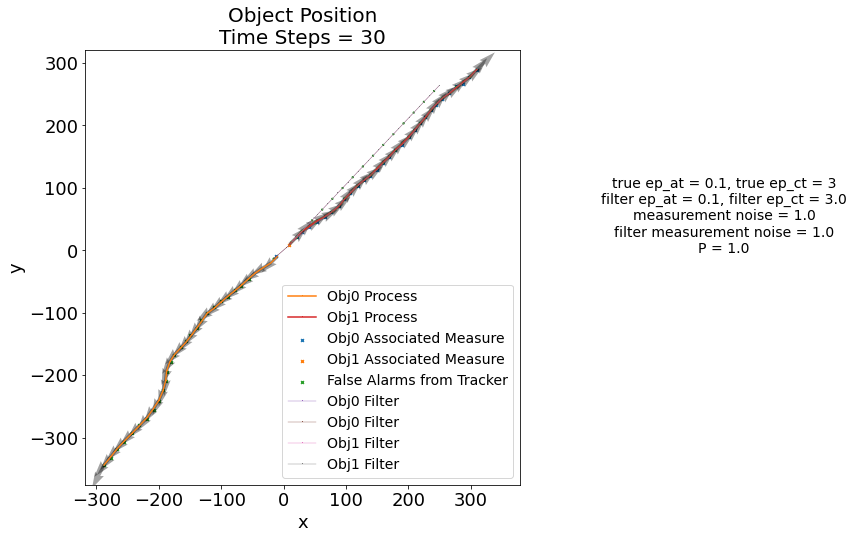

In [2]:
xt0 = np.array([[-10], [-10], [-10], [-10]])
xt01 = np.array([[10], [10], [10], [10]])
xt0.shape = (4, 1)
dt = 1
ep_normal = 3
ep_tangent = .1
nu = 1

gen = MultiObjSimple({0: xt0, 1:xt01}, dt, ep_tangent, ep_normal, nu, miss_p = 0)

distance_gating = DistanceGating(100, method="euclidean", expand_gating=5)
data_association = DataAssociation(method="euclidean")
track_maintenance = TrackMaintenance(KalmanFilter, gen.get_params(), 4, 5, 3, num_obj = 2)
filter_predict = FilterPredict()
methods = [distance_gating, data_association, track_maintenance, filter_predict]

ts = 30 #number of timesteps
sim = Simulation(gen, KalmanFilter, MTTTracker, methods=methods, seed_value=3)

sim.generate(ts)
sim.predict()
sim.plot(ellipse_freq=2);


In [3]:
# optimal parameter search for gating
def run_simulation(params, speed):
    xt0 = np.array([[20], [20], [speed], [speed]])
    xt01 = np.array([[0], [0], [speed], [speed]])
    init_vectors = {0: xt0, 1: xt01}
    num_obj = len(init_vectors)
    xt0.shape = (4, 1)
    xt01.shape = (4, 1)
    dt = 1
    ep_normal = 3
    ep_tangent = .1
    nu = 1
    ts = 30 #number of timesteps

    gate_size = params
    #gate_expand = params[1]
    gate_expand = gate_size/3
    rmses = []
    for i in range(0, 1):
        # consider wrapping this again and taking the average of that
        gen = MultiObjSimple({0: xt0, 1: xt01}, dt, ep_tangent, ep_normal, nu, miss_p = 0)

        distance_gating = DistanceGating(gate_size, method="euclidean", expand_gating=gate_expand)
        data_association = DataAssociation(method="euclidean")
        track_maintenance = TrackMaintenance(KalmanFilter, gen.get_params(), 4, 5, 3, num_obj = num_obj)
        filter_predict = FilterPredict()
        methods = [distance_gating, data_association, track_maintenance, filter_predict]

        sim = Simulation(gen, KalmanFilter, MTTTracker, methods=methods, seed_value=None)
        sim.generate(ts)
        sim.predict()
        #sim.plot(ellipse_freq = 2);

        obj0_process = []
        obj1_process = []
        for tse in sim.processes[0]: #ts is a dict
            obj0_process.append(tse[0])
            obj1_process.append(tse[1])
            
        obj0_process = np.array(obj0_process)
        obj1_process = np.array(obj1_process)
            
        obj0_pred = np.array(list(sim.tracker_model.tracks[0].predictions.values()))
        obj1_pred = np.array(list(sim.tracker_model.tracks[1].predictions.values()))
        
        rmse0 = np.sqrt(np.sum(np.square(obj0_process - obj0_pred))/len(obj0_process))
        rmse1 = np.sqrt(np.sum(np.square(obj1_process - obj1_pred))/len(obj1_process))
        
        average_rmse = (rmse0 + rmse1)/2
        max_rmse = max(rmse0, rmse1)
        return average_rmse
    
def run_simulations(params, speed):
    results = []
    for i in range(0, 10):
        results.append(run_simulation(params, speed))
    avg = sum(results)/len(results)
    maxx = max(results)
    return avg

In [4]:
# plot just error threshold
gate_size_list = np.arange(0, 40, 1)
results = []
for gs in gate_size_list:
    ge = gs/3
    results.append(run_simulations([gs, ge]))
plt.plot(gate_size_list, results)

TypeError: run_simulations() missing 1 required positional argument: 'speed'

In [ ]:
# plot 2 ways - gate size and expand gate size

gate_size_list = np.arange(0, 25, 1)
gate_expand_list = np.arange(0, 20, 1)
results = []
for gs in gate_expand_list:
    results_size = []
    for ge in gate_size_list:
        results_size.append(run_simulations([gs, ge]))
    results.append(results_size)
#

# make axes for plotting
# X = []
# for i in range(0, gate_expand_list):
#     X.append(gate_size_list)
# Y = []
# for i in range(0, gate_expand_list):
#     Y.append(gate_expand_list[i] * len(gate_size_list))
X, Y = np.meshgrid(gate_size_list, gate_expand_list)
Z = np.array(results)
    
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z)

In [ ]:
from scipy.optimize import minimize
speeds = np.arange(1, 100, 10)
results = []
for speed in speeds:
    res = minimize(run_simulations, 10 + speed/10, args=speed, method='Nelder-Mead')
    results.append(res.x)
plt.plot(speeds, results)

In [ ]:
print(results)

In [ ]:
### testing vector operations

p = np.array([[[1], [2], [3], [4]], [[5], [6], [7], [8]], [[9], [10], [11], [12]]])
t = np.array([[[1], [3], [2], [4]], [[1], [2], [3], [5]], [[1], [2], [6], [4]]])

subtract = np.subtract(p, t)
square = np.square(subtract)

errors = []
for vector in square:
    errors.append(np.sqrt(np.sum(vector)))
print(errors)

print(p.shape)
p[:, :2, ]

In [ ]:
# lin sum testing

from scipy.optimize import linear_sum_assignment

infin = 200000
cost = np.array([[infin, infin, 2], [infin, infin, 3]])
print(cost)
row_ind, col_ind = linear_sum_assignment(cost)
print(col_ind)
print(row_ind)

print('sum ' + str(cost[row_ind, col_ind].sum()))

linsum_matrix = [[1, None, 3], [None, None, None]]
for row in range(0, len(linsum_matrix)):
    for col in range(0, len(linsum_matrix[row])):
        linsum_matrix[row][col] = 10 if linsum_matrix[row][col] is None else linsum_matrix[row][col]
print(linsum_matrix)

In [ ]:
# ERROR/ACCURACY TESTING

# sim.experiment(ts, "Measurement Noise", nu = [.1])
# rmses = []
# failures = []

# for i, trial in enumerate(sim.processes):
#     process = np.array([point for sublist in sim.processes[i] for point in sublist])
#     traj = np.array([point for sublist in sim.trajectories[i] for point in sublist])
#     process = process[:, :2, ] #get first two position coordinates
    
#     #print(ste.rmse(truth = process, prediction = traj))
#     #print(ste.center_error(truth = process, prediction = traj))
#     #print(ste.failure_rate(truth = process, prediction = traj))
#     #ste.center_error_plot(truth = process, prediction = traj)
#     rmses.append(ste.rmse(truth = process, prediction = traj))
#     failures.append(ste.failure_rate(truth = process, prediction = traj))
# plt.figure()
# plt.plot(rmses)
# plt.plot(failures)

In [ ]:
dic = {0: 'hi', 1: 'bye'}
for key, value in dic.items():
    print(value)
    
print(len(dic))

In [ ]:
measure = np.array([[1], [0]])
vel = np.array([[2], [3]])
print(np.row_stack((measure, vel)))

In [ ]:
arr1 = np.array([1, 2])
print(arr1)
arr2 = {
    0: np.array([1, 2]),
    1: np.array([1, 2])}

# for r in arr2.values():
#     print(np.array_equiv(arr1, r))
# print(np.array(arr2.values()))
# arr1 in arr2.values()
# print(np.any(arr1, arr2.values()))

In [ ]:
arr1 = np.array([np.array([[1], [2]]), np.array([[1], [2]])])
arr2 = np.array([np.array([[1], [3]]), np.array([[9], [2]])])

np.sqrt(np.sum(np.square(arr1 - arr2))/len(arr1))

In [ ]:
d = {0: [[1, 3, 4], [2, 3, 5]]}
for key, value in d.items():
    print(value)
print(len(d))

In [ ]:
# test scipy optimize
from scipy.optimize import minimize, rosen, rosen_der
x0 = [1.3, 0.7, 0.8, 1.9, 1.2]
res = minimize(rosen, x0, method='Nelder-Mead')
res.x

In [ ]:
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-8, 6, 30)
y = np.linspace(-7, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
print(X)